In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('fer2013.csv')

In [33]:
data[data['emotion']==6]

,emotion,pixels,Usage
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
11,6,39 75 78 58 58 45 49 48 103 156 81 45 41 38 49...,Training
12,6,219 213 206 202 209 217 216 215 219 218 223 23...,Training
13,6,148 144 130 129 119 122 129 131 139 153 140 12...,Training
18,6,134 124 167 180 197 194 203 210 204 203 209 20...,Training
...,...,...,...
35866,6,87 82 59 61 72 102 143 130 90 95 143 173 146 1...,PrivateTest
35871,6,112 102 98 89 98 133 164 185 180 179 185 169 1...,PrivateTest
35876,6,29 29 27 31 49 56 29 19 22 20 34 43 55 71 85 9...,PrivateTest
35877,6,139 143 145 154 159 168 176 181 190 191 195 19...,PrivateTest


In [107]:
X = np.array([np.fromstring(pix_str, sep=' ') for pix_str in data['pixels']], dtype=np.float32)
X = X/255
X = pd.DataFrame(X)
data_norm = pd.concat([data['emotion'],X,data['Usage']], axis=1)

In [108]:
data_train = data_norm[data_norm['Usage']=='Training']
X_train = data_train.drop(columns=['emotion','Usage'])
y_train = data_train['emotion']

In [109]:
data_test = data_norm[data_norm['Usage']=='PrivateTest']
X_test = data_test.drop(columns=['emotion','Usage'])
y_test = data_test['emotion']

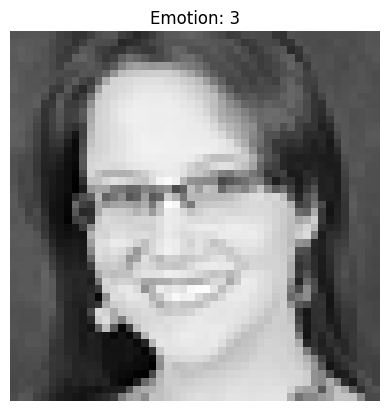

In [65]:
sample = np.array(X_train.iloc[7]).reshape(48,48)
plt.imshow(sample, cmap='gray')
plt.title(f"Emotion: {y_train[7]}")
plt.axis('off')
plt.show()

In [ ]:
#0-angry, 1 disgust, 2 fear, 3 happy, 4 sad, 5 surprise, 6 neutral

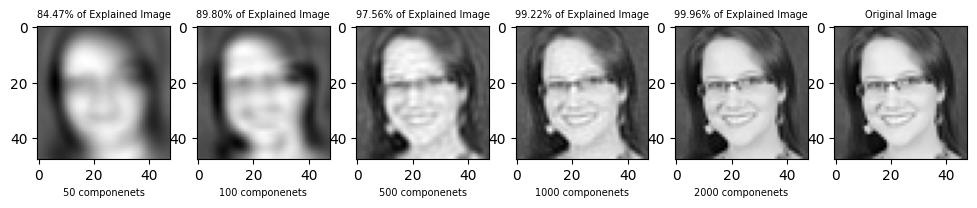

In [68]:
from sklearn.decomposition import PCA
components_list = [50, 100, 500, 1000, 2000]

or_image = np.array(X_train.iloc[7]).reshape(48,48)

fig, axes = plt.subplots(1, 6, figsize=(12, 6))
axes = axes.ravel()

axes[5].imshow(or_image, cmap='gray')
axes[5].set_title("Original Image",fontsize=7)

for i, n_components in enumerate(components_list):
    #pca
    pca_n = PCA(n_components=n_components)
    data_pca = pca_n.fit_transform(np.array(X_train))
    data_reconstr = pca_n.inverse_transform(data_pca)

    #image reconstruction
    reconst_image = data_reconstr[7].reshape(48, 48)

    #explained variance
    explained_var = np.sum(pca_n.explained_variance_ratio_)*100

    axes[i].imshow(reconst_image, cmap='gray')
    axes[i].set_title(f"{explained_var:.2f}% of Explained Image",fontsize=7)
    axes[i].set_xlabel(f"{n_components} componenets",fontsize=7)

Text(0.5, 0, '500 componenets')

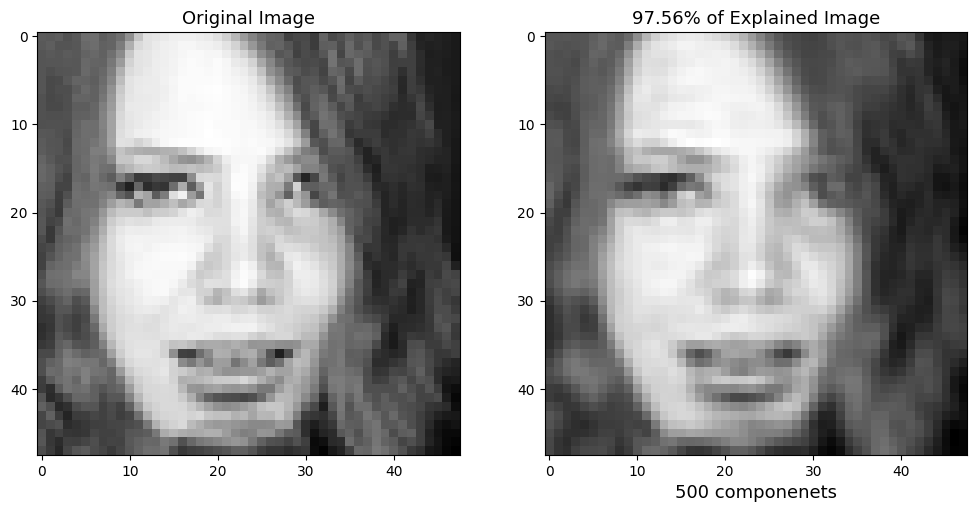

In [110]:
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.ravel()
or_image = np.array(X_train.iloc[478]).reshape(48,48)
axes[0].imshow(or_image, cmap='gray')
axes[0].set_title("Original Image",fontsize=13)

pca_n = PCA(n_components=500)
data_pca_train = pca_n.fit_transform(np.array(X_train))
data_pca_test = pca_n.transform(np.array(X_test))

data_reconstr = pca_n.inverse_transform(data_pca_train)
reconst_image = data_reconstr[478].reshape(48, 48)
explained_var = np.sum(pca_n.explained_variance_ratio_)*100
axes[1].imshow(reconst_image, cmap='gray')
axes[1].set_title(f"{explained_var:.2f}% of Explained Image",fontsize=13)
axes[1].set_xlabel(f"500 componenets",fontsize=13)

In [5]:
import umap

umap_n = umap.UMAP(n_components=500, n_jobs=-1, random_state=42)
data_umap_train = umap_n.fit_transform(X_train)
data_umap_test = umap_n.transform(X_test)

C:\Users\anastasia.golubova\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
data_umap_train_df = pd.DataFrame(data_umap_train)
data_umap_train_df.to_csv('D:/otus/umap_train.csv')

In [14]:
data_umap_test_df = pd.DataFrame(data_umap_test)
data_umap_test_df.to_csv('D:/otus/umap_test.csv')

In [117]:
data_umap_train = pd.read_csv('D:/otus/umap_train.csv',index_col=0)
data_umap_test = pd.read_csv('D:/otus/umap_test.csv',index_col=0)

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':[10,20,50],
              'metric': ['euclidean', 'manhattan']}

model = KNeighborsClassifier()
KNN = GridSearchCV(model, param_grid, cv=3, 
                   n_jobs=-1, scoring = 'accuracy')
KNN.fit(data_pca_train, y_train)
pred = KNN.predict(data_pca_test)

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print(f'Accuracy test score (PCA): {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score (PCA): {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score (PCA): {roc_auc_score(y_test, KNN.predict_proba(data_pca_test), multi_class='ovr')}")
print('Best parameters: ', KNN.best_params_)

Accuracy test score (PCA): 0.4731
F1 test score (PCA): 0.4474
ROC AUC test score (PCA): 0.7914628386206121
Best parameters:  {'metric': 'euclidean', 'n_neighbors': 10}


In [25]:
param_grid = {'n_neighbors':[10,20,50],
              'metric': ['euclidean', 'manhattan']}

model = KNeighborsClassifier()
KNN = GridSearchCV(model, param_grid, cv=3, 
                   n_jobs=-1, scoring = 'accuracy')
KNN.fit(data_umap_train, y_train)
pred = KNN.predict(data_umap_test)

In [31]:
print(f'Accuracy test score (UMAP): {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score (UMAP): {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score (UMAP): {roc_auc_score(y_test, KNN.predict_proba(data_umap_test), multi_class='ovr'):.4f}")
print('Best parameters: ', KNN.best_params_)

Accuracy test score (UMAP): 0.2764
F1 test score (UMAP): 0.2638
ROC AUC test score (UMAP): 0.6345512094892166
Best parameters:  {'metric': 'manhattan', 'n_neighbors': 20}


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200], 'max_depth':[5, 10]}

model = RandomForestClassifier()
RF = GridSearchCV(model, param_grid, cv=3, 
                  n_jobs=-1, scoring = 'accuracy')

RF.fit(data_pca_train, y_train)
pred = RF.predict(data_pca_test)

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print(f'Accuracy test score (PCA): {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score (PCA): {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score (PCA): {roc_auc_score(y_test, RF.predict_proba(data_pca_test), multi_class='ovr')}")
print('Best parameters: ', RF.best_params_)

Accuracy test score (PCA): 0.3107
F1 test score (PCA): 0.2206
ROC AUC test score (PCA): 0.71994668388046
Best parameters:  {'max_depth': 10, 'n_estimators': 100}


In [38]:
param_grid = {'n_estimators': [100, 200], 'max_depth':[5, 10]}

model = RandomForestClassifier()
RF = GridSearchCV(model, param_grid, cv=3, 
                  n_jobs=-1, scoring = 'accuracy')

RF.fit(data_umap_train, y_train)
pred = RF.predict(data_umap_test)

In [39]:
print(f'Accuracy test score (UMAP): {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score (UMAP): {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score (UMAP): {roc_auc_score(y_test, RF.predict_proba(data_umap_test), multi_class='ovr')}")
print('Best parameters: ', RF.best_params_)

Accuracy test score (UMAP): 0.2995
F1 test score (UMAP): 0.2496
ROC AUC test score (UMAP): 0.6529981963772682
Best parameters:  {'max_depth': 10, 'n_estimators': 200}


In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

model = LGBMClassifier(learning_rate=0.1)
LGB = GridSearchCV(model, param_grid, cv=3,
                   n_jobs=-1, scoring = 'accuracy')
LGB.fit(data_pca_train, y_train)
pred = LGB.predict(data_pca_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 28709, number of used features: 500
[LightGBM] [Info] Start training from score -1.972167
[LightGBM] [Info] Start training from score -4.187324
[LightGBM] [Info] Start training from score -1.946956
[LightGBM] [Info] Start training from score -1.381048
[LightGBM] [Info] Start training from score -1.782364
[LightGBM] [Info] Start training from score -2.203164
[LightGBM] [Info] Start training from score -1.754797


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print(f'Accuracy test score (PCA): {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score (PCA): {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score (PCA): {roc_auc_score(y_test, LGB.predict_proba(data_pca_test), multi_class='ovr')}")
print('Best parameters: ', LGB.best_params_)

Accuracy test score (PCA): 0.4288
F1 test score (PCA): 0.4135
ROC AUC test score (PCA): 0.7565124403693081
Best parameters:  {'max_depth': 10, 'n_estimators': 200}


In [69]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

model = LGBMClassifier(learning_rate=0.1)
LGB = GridSearchCV(model, param_grid, cv=3, 
                   n_jobs=-1, scoring = 'accuracy')
LGB.fit(data_umap_train, y_train)
pred = LGB.predict(data_umap_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.383641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 28709, number of used features: 500
[LightGBM] [Info] Start training from score -1.972167
[LightGBM] [Info] Start training from score -4.187324
[LightGBM] [Info] Start training from score -1.946956
[LightGBM] [Info] Start training from score -1.381048
[LightGBM] [Info] Start training from score -1.782364
[LightGBM] [Info] Start training from score -2.203164
[LightGBM] [Info] Start training from score -1.754797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [70]:
print(f'Accuracy test score (UMAP): {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score (UMAP): {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score (UMAP): {roc_auc_score(y_test, LGB.predict_proba(data_umap_test), multi_class='ovr')}")
print('Best parameters: ', LGB.best_params_)

Accuracy test score (UMAP): 0.3006
F1 test score (UMAP): 0.2904
ROC AUC test score (UMAP): 0.6639473940611014
Best parameters:  {'max_depth': 10, 'n_estimators': 200}


In [54]:
from skimage.feature import hog

def extract_hog_features(X, image_shape=(48, 48)):
    hog_features = []
    for row in np.array(X):
        img = row.reshape(image_shape)
        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=False
        )
        hog_features.append(features)
    return np.array(hog_features)

In [55]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

Text(0, 0.5, 'Накопленная доля дисперсии')

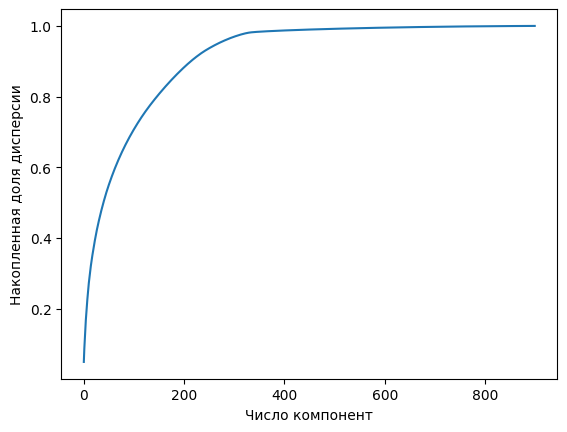

In [58]:
pca = PCA().fit(X_train_hog)

cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(cumulative_variance)
plt.xlabel('Число компонент')
plt.ylabel('Накопленная доля дисперсии')

In [59]:
pca_hog = PCA(n_components=350)
data_pca_train = pca_hog.fit_transform(np.array(X_train_hog))
data_pca_test = pca_hog.transform(np.array(X_test_hog))

In [60]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15]
}

model = LGBMClassifier(learning_rate=0.1)
LGB = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring = 'accuracy')
LGB.fit(data_pca_train, y_train)
pred = LGB.predict(data_pca_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89250
[LightGBM] [Info] Number of data points in the train set: 28709, number of used features: 350
[LightGBM] [Info] Start training from score -1.972167
[LightGBM] [Info] Start training from score -4.187324
[LightGBM] [Info] Start training from score -1.946956
[LightGBM] [Info] Start training from score -1.381048
[LightGBM] [Info] Start training from score -1.782364
[LightGBM] [Info] Start training from score -2.203164
[LightGBM] [Info] Start training from score -1.754797


In [61]:
print(f'Accuracy test score (PCA): {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score (PCA): {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score (PCA): {roc_auc_score(y_test, LGB.predict_proba(data_pca_test), multi_class='ovr')}")
print('Best parameters: ', LGB.best_params_)

Accuracy test score (PCA): 0.4806
F1 test score (PCA): 0.4686
ROC AUC test score (PCA): 0.8127203262861629
Best parameters:  {'max_depth': 15, 'n_estimators': 200}


In [62]:
param_grid = {
    'n_estimators': [100, 200],
}

model = LGBMClassifier(learning_rate=0.1, max_depth=15)
LGB = GridSearchCV(model, param_grid, cv=3, 
                   n_jobs=-1, scoring = 'accuracy')
LGB.fit(X_train_hog, y_train)
pred = LGB.predict(X_test_hog)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.752038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229500
[LightGBM] [Info] Number of data points in the train set: 28709, number of used features: 900
[LightGBM] [Info] Start training from score -1.972167
[LightGBM] [Info] Start training from score -4.187324
[LightGBM] [Info] Start training from score -1.946956
[LightGBM] [Info] Start training from score -1.381048
[LightGBM] [Info] Start training from score -1.782364
[LightGBM] [Info] Start training from score -2.203164
[LightGBM] [Info] Start training from score -1.754797


In [66]:
print(f'Accuracy test score: {accuracy_score(pred, y_test):.4f}')
print(f"F1 test score: {f1_score(y_test, pred, average='weighted'):.4f}")
print(f"ROC AUC test score: {roc_auc_score(y_test, LGB.predict_proba(X_test_hog), multi_class='ovr')}")
print('Best parameters: ', LGB.best_params_)

Accuracy test score: 0.5194
F1 test score: 0.5087
ROC AUC test score: 0.8337787727727447
Best parameters:  {'n_estimators': 200}
